# TP 1 Mesures de performance
Dans ce TP, nous aimerions avoir un premier apperçu sur les algorithmes d'apprentissage automatique. Plus précisément, nous aimerions évaluer leurs performances en utilisant les métriques suivantes:
- Matrice de conusion
- Rappel
- Précision
- Taux de FP
- Spécificité
- Courbe ROC

Les mesures devront être calculées sur la tâche de classification de nombres manuscrits.

Le travail consiste à implementer ces métriques et à les comparer avec les métriques des librairies disponibles.

Les algorithmes : K plus Proches Voisins devront être implementés.

# Importation des librairies necessaires au travail

In [39]:
import time
import numpy as np
import pandas as pd
import math
import cv2 
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import random
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier

In [40]:
# Pour RNC
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD

# Lecture des fichiers de données à classifier
Pour ce TP, nous allons lire les données à partir d'un fichier csv.

In [41]:
# données
X = np.genfromtxt('data.csv', delimiter=',', dtype=int)
X.shape

(5000, 400)

In [42]:
# étiquettes
Y = np.genfromtxt('labels.csv', delimiter=',', dtype=int)
Y.shape

(5000,)

Afficher aléatoirement quelques données de notre base

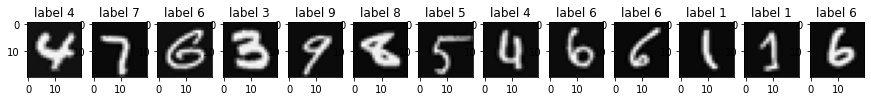

In [43]:
plt.figure(figsize=(15,8))
for i in range(13):
    c = random.randint(X.shape[0])
    a = X[c,:].reshape((20, 20))
    a=np.transpose(a)
    plt.subplot(1,13,i+1)
    plt.title('label '+ str(Y[c]))
    plt.imshow(a,cmap='gray')

Notons que l'étiquette 10 concerne le chiffre 0. L'étiquette a été utilisée ainsi afin de faciliter les calculs conséquents.

# Implémentation des métriques demandées
Ici il faut écrire les fonctions, puis les appeler dans la suite du code

- Matrice de confusion

In [64]:
actual = np.array([9, 10, 1, 1, 3, 5, 5, 6, 1, 3, 8, 7])
predicted = np.array([9, 10, 1, 5, 3, 6, 5, 5, 1, 8, 8, 4])
nbClasses = 10
def confusionMatrix(predicted, actual):
    m = np.zeros((nbClasses, nbClasses), np.intc)
    for i in range(predicted.size):
        m[predicted[i]-1][actual[i]-1] += 1
    return m

mc = confusionMatrix(predicted, actual)
#print(mc)

- Rappel


In [65]:
def rappel(mc):
    s = 0
    for i in range(nbClasses):
        VP, FN = mc[i][i], 0
        for j in range(nbClasses):
            if i != j:
                FN += mc[j][i]
        if (VP != 0) & (FN != 0):
            s += (VP / (VP+FN))
    return (s / nbClasses)

print('rappel =', rappel(mc))

rappel = 0.16666666666666666


- Précision

In [66]:
def precision(mc):
    s = 0
    for i in range(nbClasses):
        VP, FP = mc[i][i], 0
        for j in range(nbClasses):
            if i != j:
                FP += mc[i][j]
        if (VP != 0) & (FP != 0):
            s += (VP / (VP+FP))
    return (s / nbClasses)

print('precision =', precision(mc))

precision = 0.08333333333333333


- Taux de FP

In [67]:
def tauxFP(mc):
    s = 0
    for i in range(nbClasses):
        FP, TN = 0, 0
        for j in range(nbClasses):
            if j != i:
                FP += mc[i][j]
            for k in range(nbClasses):
                if (j != i) & (k != i):
                    TN += mc[j][k]
        if (FP != 0) & (TN != 0):
            s += (FP / (FP+TN))
    return (s / nbClasses)

print('teax de FP =', tauxFP(mc))

teax de FP = 0.04651515151515152


- Spécificité

In [68]:
def specificite(taux_fp):
    return (1 - taux_fp)

print('spécificité =', specificite(tauxFP(mc)))

spécificité = 0.9534848484848485


- Courbe ROC

In [69]:
def ROC(Ytt, p_proba):
    roc_x, roc_y = [], []
    for i in range(nbClasses):
        x, y = [], []
        threashold = 0
        while threashold <= 11:
            mc = np.zeros((2, 2), np.intc)
            for j, x_proba in enumerate(p_proba):
                if (x_proba[i] >= (threashold/10)):
                    if (Ytt[j] == i+1):
                        mc[1][1] += 1
                    else:
                        mc[1][0] += 1
                elif (x_proba[i] < (threashold/10)):
                    if (Ytt[j] == i+1):
                        mc[0][1] += 1
                    else:
                        mc[0][0] += 1
            #FPR
            FPR = mc[1][0] / (mc[1][0] + mc[0][0])
            x.append(FPR)
            #TPR
            TPR = mc[1][1] / (mc[1][1] + mc[0][1])
            y.append(TPR)
            threashold += 1
        roc_x.append(x)
        roc_y.append(y)
    return [roc_x, roc_y]

# Classification

Définir d'abord la base d'entrainement Xt, Yt et la base de test Xtt, Ytt

In [70]:
tRatio=2/3
ttRatio=1/3
Xt, Xtt, Yt, Ytt = train_test_split(X, Y, test_size = ttRatio)

# Méthode 0: K- Plus Proches Voisins

Ici il faudra implémenter la méthode, puis la tester et vérifier les métriques en variant le nombre K

In [72]:
p_proba=[]
def KPP(x, X, Y, k):
    # Il faudra retourner l'etiquette de x, en le comparant à toutes les données de Xt, Yt
    all_distances = []
    nearest_neighbors = []
    global p_proba
    vecteur_proba = [0.] * nbClasses
    
    for item in X:
        distance = 0
        for i in range(len(x)):
            distance += pow((x[i] - item[i]), 2)
        all_distances.append(math.sqrt(distance))

    dist_class = dict(zip(all_distances, Y))
    frequance = {}
    i = 1
    for key in sorted(dist_class.keys()):
        if i <= k:
            frequance[dist_class[key]] = frequance.get(dist_class[key], 0) + 1
            i += 1
        if i > k: 
            break
        
    p_class = max(frequance, key= lambda x: frequance[x])

    for key in frequance.keys():
        vecteur_proba[key - 1] = frequance[key] / k

    p_proba.append(vecteur_proba)
    return p_class

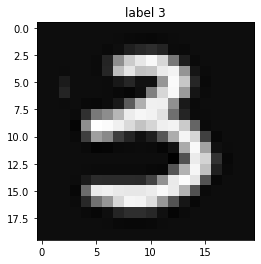

In [71]:
# tester une image
c = 0
res = KPP(Xtt[c], Xt, Yt, 13)
a = Xtt[c,:].reshape((20, 20))
a = np.transpose(a)
plt.title('label '+ str(res))
plt.imshow(a,cmap='gray')

In [73]:
y_pred = []
p_proba = []
k = 11
time_1 = time.time()
for x in Xtt:
    y_pred.append(KPP(x, Xt, Yt, k))

p_proba = np.asarray(p_proba)
time_2 = time.time()

print('Done after', time_2 - time_1)

Done after 2050.509181499481


rappel = 0.9324772026701711
precision = 0.9325391154087834
teax de FP = 0.007664121504305002
spécificité = 0.992335878495695


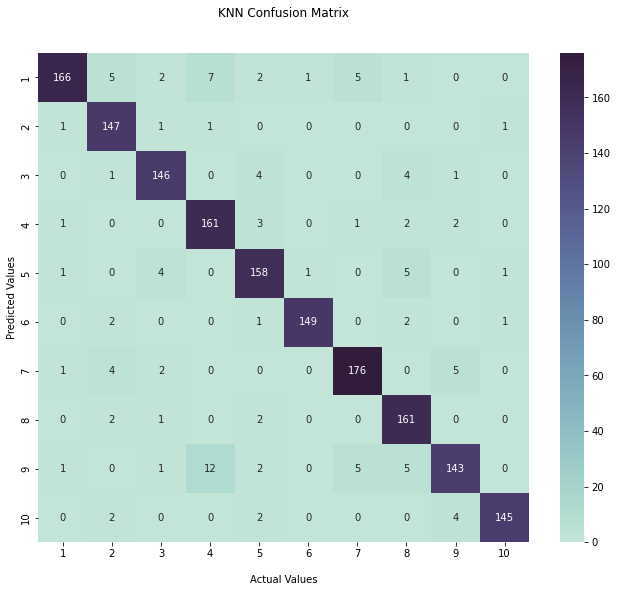

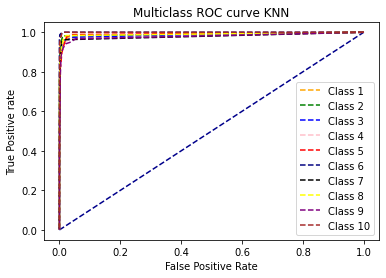

In [74]:
roc = ROC(Ytt, p_proba)

y_pred = np.array(y_pred)
mc = confusionMatrix(y_pred, Ytt)
#print(mc)

print('rappel =', rappel(mc))
print('precision =', precision(mc))
print('teax de FP =', tauxFP(mc))
print('spécificité =', specificite(tauxFP(mc)))

plt.figure(figsize=(11,9))

ax = sns.heatmap(mc, annot=True, fmt='', cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True))

ax.set_title('KNN Confusion Matrix\n\n')
ax.set_xlabel('\nActual Values')
ax.set_ylabel('Predicted Values')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
ax.yaxis.set_ticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

## Display the visualization of the Confusion Matrix.
plt.show()

plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.plot(roc[0][0], roc[1][0], linestyle='--',color='orange', label='Class 1')
plt.plot(roc[0][1], roc[1][1], linestyle='--',color='green', label='Class 2')
plt.plot(roc[0][2], roc[1][2], linestyle='--',color='blue', label='Class 3')
plt.plot(roc[0][3], roc[1][3], linestyle='--',color='pink', label='Class 4')
plt.plot(roc[0][4], roc[1][4], linestyle='--',color='red', label='Class 5')
plt.plot(roc[0][5], roc[1][5], linestyle='--',color='navy', label='Class 6')
plt.plot(roc[0][6], roc[1][6], linestyle='--',color='black', label='Class 7')
plt.plot(roc[0][7], roc[1][7], linestyle='--',color='yellow', label='Class 8')
plt.plot(roc[0][8], roc[1][8], linestyle='--',color='purple', label='Class 9')
plt.plot(roc[0][9], roc[1][9], linestyle='--',color='brown', label='Class 10')
plt.title('Multiclass ROC curve KNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300)

# Méthode 1: MVS
Machine à Vecteurs de Support

In [75]:
#Créer le modèle
model= svm.SVC(kernel='linear',probability=True) 
# entrainement 
model.fit(Xt, Yt)
# Prediction
y_pred = model.predict(Xtt)

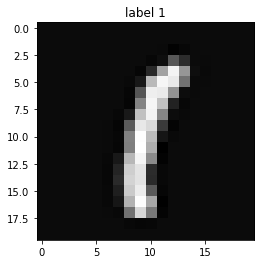

In [76]:
# tester une image
c = 3
a = Xtt[c,:].reshape((20, 20))
a = np.transpose(a)
plt.title('label '+ str(y_pred[c]))
plt.imshow(a,cmap='gray')

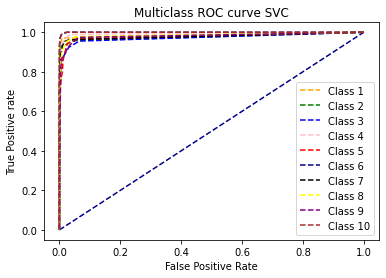

In [77]:
y_prob=model.predict_proba(Xtt)
roc=ROC(Ytt,y_prob)

plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.plot(roc[0][0], roc[1][0], linestyle='--',color='orange', label='Class 1')
plt.plot(roc[0][1], roc[1][1], linestyle='--',color='green', label='Class 2')
plt.plot(roc[0][2], roc[1][2], linestyle='--',color='blue', label='Class 3')
plt.plot(roc[0][3], roc[1][3], linestyle='--',color='pink', label='Class 4')
plt.plot(roc[0][4], roc[1][4], linestyle='--',color='red', label='Class 5')
plt.plot(roc[0][5], roc[1][5], linestyle='--',color='navy', label='Class 6')
plt.plot(roc[0][6], roc[1][6], linestyle='--',color='black', label='Class 7')
plt.plot(roc[0][7], roc[1][7], linestyle='--',color='yellow', label='Class 8')
plt.plot(roc[0][8], roc[1][8], linestyle='--',color='purple', label='Class 9')
plt.plot(roc[0][9], roc[1][9], linestyle='--',color='brown', label='Class 10')
plt.title('Multiclass ROC curve SVC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300)

# Méthode 2: Arbres de décision


In [78]:
# Créer le modèle
model = DecisionTreeClassifier()
# Entrainer le modèle
model = model.fit(Xt, Yt)
# Prediction
y_pred = model.predict(Xtt)

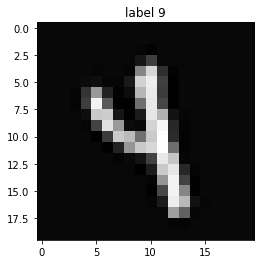

In [79]:
# tester une image
c = 7
a = Xtt[c,:].reshape((20, 20))
a = np.transpose(a)
plt.title('label '+ str(y_pred[c]))
plt.imshow(a,cmap='gray')

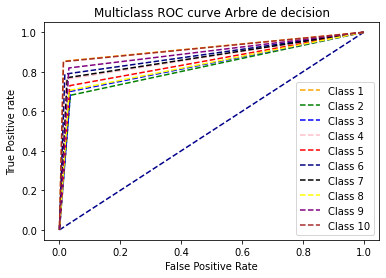

In [80]:
y_probs=model.predict_proba(Xtt)
roc=ROC(Ytt,y_probs)

plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.plot(roc[0][0], roc[1][0], linestyle='--',color='orange', label='Class 1')
plt.plot(roc[0][1], roc[1][1], linestyle='--',color='green', label='Class 2')
plt.plot(roc[0][2], roc[1][2], linestyle='--',color='blue', label='Class 3')
plt.plot(roc[0][3], roc[1][3], linestyle='--',color='pink', label='Class 4')
plt.plot(roc[0][4], roc[1][4], linestyle='--',color='red', label='Class 5')
plt.plot(roc[0][5], roc[1][5], linestyle='--',color='navy', label='Class 6')
plt.plot(roc[0][6], roc[1][6], linestyle='--',color='black', label='Class 7')
plt.plot(roc[0][7], roc[1][7], linestyle='--',color='yellow', label='Class 8')
plt.plot(roc[0][8], roc[1][8], linestyle='--',color='purple', label='Class 9')
plt.plot(roc[0][9], roc[1][9], linestyle='--',color='brown', label='Class 10')
plt.title('Multiclass ROC curve Arbre de decision')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300)


# Méthode 3: RN 
Réseaux de neurones Perceptron

In [81]:
model = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(25),max_iter=100000)
Xt, Xtt, Yt, Ytt = train_test_split(X, Y, random_state=0, test_size=0.7)
model.fit(Xt, Yt)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=25, max_iter=100000, solver='sgd')

In [82]:
# Choisir un image de test 
c = 0

In [83]:
model.predict([Xtt[c,:]])

array([10])

In [84]:
# pour ROC, il faudra les probabilités:
model.predict_proba([Xtt[c,:]])

array([[4.06585852e-097, 1.69294591e-082, 7.07909370e-040,
        9.73383666e-065, 2.01730838e-034, 7.38952278e-088,
        8.13055226e-004, 1.05780357e-036, 5.56468778e-116,
        9.99186945e-001]])

Afficher l'image testée

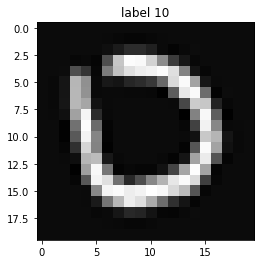

In [85]:
a = Xtt[c,:].reshape((20, 20))
a = np.transpose(a)
plt.title('label '+ str(Ytt[c]))
plt.imshow(a,cmap='gray')

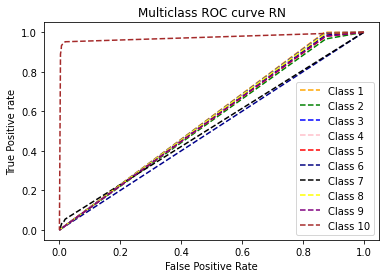

In [86]:
y_predRN=model.predict(Xtt)
y_probRN=model.predict_proba(Xtt)
roc=ROC(Ytt,y_probRN)

plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.plot(roc[0][0], roc[1][0], linestyle='--',color='orange', label='Class 1')
plt.plot(roc[0][1], roc[1][1], linestyle='--',color='green', label='Class 2')
plt.plot(roc[0][2], roc[1][2], linestyle='--',color='blue', label='Class 3')
plt.plot(roc[0][3], roc[1][3], linestyle='--',color='pink', label='Class 4')
plt.plot(roc[0][4], roc[1][4], linestyle='--',color='red', label='Class 5')
plt.plot(roc[0][5], roc[1][5], linestyle='--',color='navy', label='Class 6')
plt.plot(roc[0][6], roc[1][6], linestyle='--',color='black', label='Class 7')
plt.plot(roc[0][7], roc[1][7], linestyle='--',color='yellow', label='Class 8')
plt.plot(roc[0][8], roc[1][8], linestyle='--',color='purple', label='Class 9')
plt.plot(roc[0][9], roc[1][9], linestyle='--',color='brown', label='Class 10')
plt.title('Multiclass ROC curve RN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300)

# Méthode 4: RNC
Réseaux de Neurones Convolutifs

In [87]:
# reshape dataset to have a single channel
Xt, Xtt, Yt, Ytt = train_test_split(X, Y, random_state=0, test_size=0.7)

Xt_rnc = Xt.reshape((Xt.shape[0], 20, 20, 1))
Xtt_rnc = Xtt.reshape((Xtt.shape[0], 20, 20, 1))

In [88]:
# Recoder le valeurs
Yt_rnc = to_categorical(Yt)
Ytt_rnc = to_categorical(Ytt)

Xt_rncN = Xt_rnc.astype('float32')
Xtt_rncN = Xtt_rnc.astype('float32')

# normaliser
Xt_rncN = Xt_rncN / 255.0
Xtt_rncN = Xtt_rncN / 255.0

# definir le modèle RNC
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(20, 20, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))
# compiler le modèle
opt = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# evaluaer le modèle
try :
    _, acc = model.evaluate(Xtt_rncN, Ytt_rnc, verbose=0)
except ValueError:
    print("Exception in user code", ValueError)


Exception in user code <class 'ValueError'>


# Appliquer les métriques implementées pour voir le résultat

# Consignes

Le travail est à remettre par groupe de 4 au maximum [1..4].

Le délai est le vendredi 4 Mars 2022 à 22h

La partie RNC peut être laissée pour le prochain TP

In [ ]:
# bonne chance